In [1]:
import time
import inspect
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import preprocess, features, classifier, metrics, logging

In [2]:
seed = 42
np.random.seed(seed)
models_path = 'models'  # folder of models

In [21]:
logger2 = logging.Logger('log/log2.csv')
logger2.leadboard(col='val_score', top=5)
# logger2.init_log()

,version,epoch,seed,init,features,datasets,train_time,timestamp,train_loss,val_loss,train_score,val_score,train_aprox,val_aprox,batch_size,weight_decay,beam,description


In [4]:
logger1 = logging.Logger('log/log1.csv')
logger1.leadboard(col='val_score', top=5)
# logger1.init_log()

,version,epoch,seed,init,features,datasets,train_time,timestamp,train_loss,val_loss,train_score,val_score,train_aprox,val_aprox,batch_size,weight_decay,beam,description
1,12,90,42,def w0_uniform_0_1():\n return np.random.ra...,def create_feats(prints=True):\n group_thre...,def load_datasets():\n train_dataset = prep...,986.881775,10:43:00 25-04-2020,1.617005,3.183868,0.0,0.927096,0,0,5000,0.0,1,"train1, comp1_acc=0.9270961448746766, 33 feat_..."
0,12,87,42,def w0_uniform_0_1():\n return np.random.ra...,def create_feats(prints=True):\n group_thre...,def load_datasets():\n train_dataset = prep...,947.885913,10:03:56 25-04-2020,1.653636,3.198782,0.0,0.924679,0,0,5000,0.0,1,"train1, comp1_acc=0.9246787395563849, 33 feat_..."


In [5]:
def load_datasets():
#     train_dataset = preprocess.Dataset('data/train1.wtag')
#     val_dataset = preprocess.Dataset('data/comp1_tagged.wtag')

    train_dataset = preprocess.Dataset('data/train2.wtag')
    val_dataset = preprocess.Dataset('data/comp2_tagged.wtag')
    return train_dataset, val_dataset

train_dataset, val_dataset = load_datasets()
tags = train_dataset.tags.union(val_dataset.tags)

In [6]:
def create_feats(prints=True):
    group_thresholds = {
        # -------------------------------- feature --------------------- | -- Threshold --
        lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
        lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
        lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
        lambda t2, t1, w, i, t: tuple([t]):                                       1,     # mandatory feature f105
        lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       1,     # mandatory feature has_uppercase
        lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 1,     # mandatory feature has_digits
        lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            10,
    }

    tic = time.time()
    feature_vector = features.create_feature_vector(dataset=train_dataset,
                                                    group_thresholds=group_thresholds,
                                                    pruning=True,
                                                    get_stats=False,
                                                    assertions=True,
                                                    calls_counter=False)

    if prints:
        print('feature_vector creation time:', time.time() - tic, 'sec\n')
        for feat in feature_vector.feats:
            print('feat_group:', feat, '| feats:', len(feat))
    print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
    return feature_vector

feature_vector = create_feats(prints=True)

feature_vector creation time: 0.17348623275756836 sec

feat_group: FeatureGroup(tuple([w[i].lower(), t])) | feats: 1736
feat_group: FeatureGroup(tuple([w[i][-4:].lower(), t])) | feats: 170
feat_group: FeatureGroup(tuple([w[i][-3:].lower(), t])) | feats: 165
feat_group: FeatureGroup(tuple([w[i][-2:].lower(), t])) | feats: 145
feat_group: FeatureGroup(tuple([w[i][-1:].lower(), t])) | feats: 96
feat_group: FeatureGroup(tuple([w[i][:4].lower(), t])) | feats: 158
feat_group: FeatureGroup(tuple([w[i][:3].lower(), t])) | feats: 170
feat_group: FeatureGroup(tuple([w[i][:2].lower(), t])) | feats: 200
feat_group: FeatureGroup(tuple([w[i][:1].lower(), t])) | feats: 133
feat_group: FeatureGroup(tuple([t2, t1, t])) | feats: 598
feat_group: FeatureGroup(tuple([t1, t])) | feats: 216
feat_group: FeatureGroup(tuple([t])) | feats: 31
feat_group: FeatureGroup(tuple([w[i].islower(), t])) | feats: 43
feat_group: FeatureGroup(tuple([any(char.isdigit() for char in w[i]), t])) | feats: 35
feat_group: FeatureG

In [7]:
# def create_feats(prints=True):
#     group_thresholds = {
#         # -------------------------------- feature --------------------- | -- Threshold --
#         lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
# #         lambda t2, t1, w, i, t: tuple([w[i-1].lower(), w[i].lower(), w[i+1].lower(), t]):                 10,
# #         lambda t2, t1, w, i, t: tuple([w[i-2].lower(), w[i-1].lower(), w[i].lower(), t]):                 10,
# #         lambda t2, t1, w, i, t: tuple([w[i].lower(), w[i+1].lower(), w[i+2].lower(), t]):                 10,
#         lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,
#         lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
#         lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
#         lambda t2, t1, w, i, t: tuple([t]):                                       0,     # mandatory feature f105
#         lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       0,     # mandatory feature has_uppercase (inverted)
#         lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 0,     # mandatory feature has_digits
#         lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple(['-' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple(['.' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple([',' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple(['\/' in w[i], t]):                         0,
#         lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            0,
#         lambda t2, t1, w, i, t: tuple([len(w), t]):                               5,
#         lambda t2, t1, w, i, t: tuple([i, t]):                                    10,
#         lambda t2, t1, w, i, t: tuple([i==len(w)-1, t]):                          0,

#         lambda t2, t1, w, i, t: tuple([w[i-1].isalnum(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isalpha(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isascii(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isdecimal(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isdigit(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isnumeric(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].istitle(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isupper(), t]):                     0,

#         lambda t2, t1, w, i, t: tuple([w[i+1].isalnum(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isalpha(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isascii(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isdecimal(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isdigit(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isnumeric(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].istitle(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isupper(), t]):                     0,
#     }

#     tic = time.time()
#     feature_vector = features.create_feature_vector(dataset=train_dataset,
#                                                     group_thresholds=group_thresholds,
#                                                     pruning=True,
#                                                     get_stats=False,
#                                                     assertions=True,
#                                                     calls_counter=False)

#     if prints:
#         print('feature_vector creation time:', time.time() - tic, 'sec\n')
#         for feat in feature_vector.feats:
#             print('feat_group:', feat, '| feats:', len(feat))
#     print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
#     return feature_vector

# feature_vector = create_feats(prints=True)

In [8]:
def w0_uniform_0_1_centered_normalized():
    w0 = np.random.rand(len(feature_vector))
    w0 -= w0.mean()
    w0 /= w0.std()
    return w0

def w0_uniform_0_1_normalized():
    w0 = np.random.rand(len(feature_vector))
    w0 /= w0.std()
    return w0

def w0_uniform_0_1_centered():
    w0 = np.random.rand(len(feature_vector))
    w0 -= w0.mean()
    return w0

def w0_uniform_0_1():
    return np.random.rand(len(feature_vector))

def w0_xavier():
    return np.random.randn(len(feature_vector))*np.sqrt(1/len(feature_vector))

def w0_zero():
    return np.zeros(len(feature_vector)).astype(np.float32)

w0_init = w0_uniform_0_1
w0 = w0_init()

In [22]:
model = classifier.load_model(version=2.1,
                              models_path=models_path,
                              epoch=-1,
                              seed=42,
                              prints=True)

model version: 2.1
epochs: 44
train_time: 40.407

last train_loss: 1.376101
last val_loss: 6.598743
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 44


In [7]:
version = 15
epoch = -1
load = False  # load last weights, log and feature_vector into model

model = classifier.Model(version=version,
                         w0=w0_init(),
                         tags=train_dataset.tags,
                         inference=classifier.viterbi,
                         feature_vector=feature_vector,
                         score_func=metrics.accuracy,
                         models_path=models_path,
                         max_weights_history=5,
                         save=False)

if load:
    model.load(weights=True, weights_history=True, feature_vector=True, log=True, epoch=epoch, prints=True)

In [ ]:
train_save = False  # save model after each training epoch, if False model will need to be saved manually
beam = 1  # viterbi beam size for model evaluation during training
train_aprox = 0  # aproximate train_score with first train_aprox train samples
val_aprox = 0  # aproximate val_score with first val_aprox train samples 
weight_decay = 0.0  # lamda regularization parameter
init_batch_size = 250  # batch_size for loader
batch_growth = 0
epochs = 200  # training epochs
tqdm_bar = False  # display tqdm progress bars
description = f"train2, {len(feature_vector.feats)} feat_groups, {len(feature_vector)} total_feats"

v_min, f_min, d_min = model.train(epochs=epochs,
                                  train_dataset=train_dataset,
                                  val_dataset=val_dataset,
                                  batch_size=init_batch_size,
                                  weight_decay=weight_decay,
                                  save=train_save,
                                  tqdm_bar=tqdm_bar,
                                  beam=beam,
                                  train_aprox=train_aprox,
                                  val_aprox=val_aprox,
                                  batch_growth=batch_growth)

In [10]:
# # recalculate best INDs
# best_loss = 9999.9
# for i in model.log.index:
#     best = model.log.loc[i]['val_loss'] < best_loss
#     if best:
#         model.log.loc[i, 'best'] = True
#         best_loss = model.log.loc[i]['val_loss']
# model.save(epoch=True)

In [26]:
model = classifier.load_model(version=2.2,
                              models_path=models_path,
                              epoch=-1,
                              seed=42,
                              prints=True)

model version: 2.2
epochs: 30
train_time: 15.766

last train_loss: 2.817186
last val_loss: 6.461998
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 30


In [27]:
aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}
dataset = val_dataset
logger = logger2

for predict_beam in [1]:  # viterbi beam size
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc=model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags']),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = \
                                        metrics.confusion_matrix(tags,
                                                                 beam_stats[predict_beam]['pred_tags'],
                                                                 beam_stats[predict_beam]['true_tags'])
model.comp_preds = beam_stats
comp_acc = model.score_func(model.comp_preds[1]['pred_tags'], model.comp_preds[1]['true_tags'])
model.save(manual_path='model_V{:}_E0{:}_comp_acc{:.4f}.pth'.format(model.version, model.get_log(), comp_acc))

description = f"comp_acc={comp_acc}, {len(feature_vector.feats)} feat_groups, {len(feature_vector)} total_feats"
logger.log(model, w0_init, create_feats, load_datasets, description, manual_cols = {'val_score': comp_acc})

100%|██████████| 1000/1000 [13:49<00:00,  1.21it/s, acc=0.923]


In [28]:
display(logger.leadboard(col='val_loss'))

,version,epoch,seed,init,features,datasets,train_time,timestamp,train_loss,val_loss,train_score,val_score,train_aprox,val_aprox,batch_size,weight_decay,beam,description
1,2.2,30,42,def w0_uniform_0_1():\n return np.random.ra...,def create_feats(prints=True):\n group_thre...,def load_datasets():\n# train_dataset = pr...,15.766395,08:25:04 25-04-2020,2.817186,6.461998,0.0,0.923282,0,0,250,0.0,1,"comp_acc=0.9232824275290084, 33 feat_groups, 4..."
0,2.1,44,42,def w0_uniform_0_1():\n return np.random.ra...,def create_feats(prints=True):\n group_thre...,def load_datasets():\n# train_dataset = pr...,40.406914,00:32:05 25-04-2020,1.376101,6.598743,0.0,0.925276,0,0,250,0.0,1,"comp_acc=0.9252761274372981, 33 feat_groups, 4..."


In [21]:
val_loss = classifier._loss_and_grad(v=model.weights,
                                     model=model,
                                     epochs=0,
                                     train_dataset=None,
                                     val_dataset=test1_dataset,
                                     train=False,
                                     weight_decay=0.0,
                                     batch_size=None,
                                     save=False,
                                     tqdm_bar=True,
                                     beam=0,
                                     train_aprox=0,
                                     val_aprox=0,
                                     batch_growth=None)
val_loss

100%|██████████| 23674/23674 [00:33<00:00, 701.04it/s]


3.1838684549489193

In [30]:
# best_model = classifier.load_model(from_file='model_V12_E087_comp_acc0.9247.pth')
best_model = classifier.load_model(from_file='model_V12_E090_comp_acc0.9271.pth')

model version: 12
epochs: 90
train_time: 986.882

last train_loss: 1.617005
last val_loss: 3.183868
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 90


In [27]:
lst = []

In [59]:
lst.append(np.random.rand())
lst = lst[-5:]
lst

[0.8826363431893397,
 0.18870710834137938,
 0.2788713525921819,
 0.7003578299727713,
 0.8466611422383059]

In [15]:
model.avg_weights(save=False)

In [17]:
val_loss = classifier._loss_and_grad(v=model.weights,
                                     model=model,
                                     epochs=0,
                                     train_dataset=None,
                                     val_dataset=test1_dataset,
                                     train=False,
                                     weight_decay=0.0,
                                     batch_size=None,
                                     save=False,
                                     tqdm_bar=True,
                                     beam=0,
                                     train_aprox=0,
                                     val_aprox=0,
                                     batch_growth=None)
val_loss

100%|██████████| 23579/23579 [00:33<00:00, 697.52it/s]


5.977689309380855

In [ ]:
val1_dataset = preprocess.Dataset('data/test1.wtag')
aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}
dataset = val1_dataset
# dataset = comp_dataset

for predict_beam in [1]:  # viterbi beam size
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc=model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags']),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = \
                                        metrics.confusion_matrix(tags,
                                                                 beam_stats[predict_beam]['pred_tags'],
                                                                 beam_stats[predict_beam]['true_tags'])
# model.comp_preds = beam_stats
model.val_preds = beam_stats
model.save(manual_path='model_V12_E076_comp_test_preds.pth')

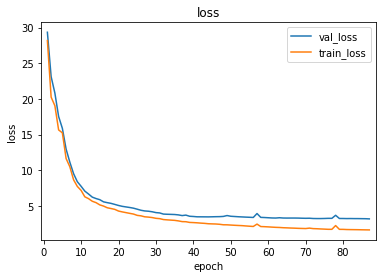

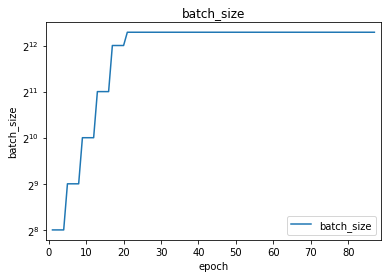

In [21]:
model.plot(['val_loss', 'train_loss'], 'loss', 'loss', scale='linear', basey=10)
model.plot(['batch_size'], 'batch_size', 'batch_size', scale='log', basey=2)

In [ ]:
best_model = classifier.load_model(from_file='checkpoint_V11_E081_0.952_SEED42.pth')
best_model.log

In [19]:
model.beam_stats[1]['matrix'][worst_tags].loc[worst_tags].T

,NN,JJ,NNP,RB,IN,VBN,NNS,VBD,VB,VBP,...,WP,-LRB-,TO,:,-RRB-,WRB,EX,WP$,``,SYM
NN,3133,94,15,11,3,5,9,3,18,12,...,0,0,0,0,0,0,0,0,0,0
JJ,112,1299,23,22,1,28,1,1,7,6,...,0,0,0,0,0,0,0,0,0,0
NNP,26,26,1916,0,3,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RB,3,12,1,713,52,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
IN,2,1,0,18,2479,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
VBN,0,32,0,0,0,431,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
NNS,35,2,8,1,0,0,1432,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VBD,2,8,1,0,0,33,0,791,2,6,...,0,0,0,0,0,0,0,0,0,0
VB,16,8,0,6,1,1,0,1,540,16,...,0,0,0,0,0,0,0,0,0,0
VBP,7,1,0,0,0,0,0,7,11,283,...,0,0,0,0,0,0,0,0,0,0


In [16]:
model.beam_stats[1]['worst']

{'NN': 0.9806116414632086,
 'JJ': 0.9823434991974318,
 'NNP': 0.9930725690631073,
 'RB': 0.9935372138210695,
 'IN': 0.9941285798766579,
 'VBN': 0.9943397820393681,
 'NNS': 0.9948044267973304,
 'VBD': 0.9959871589085072,
 'VB': 0.9960293993410493,
 'VBP': 0.9968319675593478,
 'NNPS': 0.9969164484244318,
 'VBG': 0.9969586888569739,
 'JJR': 0.9977190166427304,
 'VBZ': 0.9980146996705246,
 'RBR': 0.998479344428487,
 'DT': 0.9986483061586551,
 'RP': 0.9987750274562811,
 'CD': 0.9991129509166173,
 'WDT': 0.9992396722142435,
 'JJS': 0.9993663935118695,
 'RBS': 0.9995353552420376,
 'POS': 0.9996620765396638,
 'PDT': 0.9997465574047478,
 '#': 0.9997887978372898,
 'MD': 0.9997887978372898,
 'UH': 0.9998310382698319,
 'FW': 0.9998732787023739,
 'CC': 0.9998732787023739,
 'PRP': 0.9999155191349159,
 "''": 0.9999155191349159,
 'PRP$': 0.9999155191349159,
 '$': 0.9999577595674579,
 '.': 0.9999577595674579,
 ',': 1.0,
 'WP': 1.0,
 '-LRB-': 1.0,
 'TO': 1.0,
 ':': 1.0,
 '-RRB-': 1.0,
 'WRB': 1.0,
 'EX'

In [26]:
model.beam_stats = beam_stats
model.save()

In [ ]:
display(matrix1)
display(matrix2)

In [ ]:
display(worst1)
display(worst2)

### Code that may be useful

In [ ]:
# sentences = {}
# for sentence in train_dataset.sentences:
#     sentences[len(sentence[0])] = sentence

In [ ]:
# %%time
# sample_sentence = (['Terms', 'were', "n't", 'disclosed', '.'],  # sentence words
#                    ['NNS',   'VBD',  'RB',  'VBN',       '.'])  # sentence true tags
# predict_beam = 100  # viterbi beam size

# tags, bp_pi = viterbi(model, sample_sentence[0], beam=predict_beam)
# print('sentence ', sample_sentence[0])
# print('true tags', sample_sentence[1])
# print('pred tags', tags)
# print()

In [7]:
%%time
sum_vec = np.zeros(len(feature_vector)).astype(np.float32)
sum_inds = 0
for t2, t1, w, i, t in train_dataset:
    vec = feature_vector(t2, t1, w, i, t, fmt='vec')
    sum_vec += vec
    sum_inds += (vec).sum()

df = pd.DataFrame(sum_vec, columns=['feat']).astype({'feat': int}).sort_values('feat', ascending=False)
print(sum_vec.sum())
print(sum_inds/len(train_dataset.sentences))
display(df.head(50))

3802186.0
760.4372


,feat
32871,16939
42333,16939
42378,16939
42289,16939
42423,16939
...,...
7471,1
7472,1
13388,1
7476,1


CPU times: user 28.2 s, sys: 15.6 ms, total: 28.3 s
Wall time: 28.8 s


In [13]:
display(df.loc[0:100].head(50))

,feat
0,6199
17008,6199
19968,6199
42480,6044
24990,6044
19758,6044
20012,6044
56,6044
26421,6044
42299,6044


In [15]:
feat, key = feature_vector.invert_feat(4914)  # 41453 22811
print(feat)
print(key)


FeatureGroup(tuple([w[i].lower(), t]))
('low-density', 'NN')


In [ ]:
# # test run train_dataset
# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t = feature_vector(t2, t1, w, i, t, fmt='vec')
# print('fmt=vec: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_list_t = feature_vector(t2, t1, w, i, t, fmt='list')
# print('fmt=list: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t, feat_list_t = feature_vector(t2, t1, w, i, t, fmt='both')
# print('fmt=vec+list: {:.3f} sec'.format(time.time() - tic))

In [ ]:
# for tag in train1_statistics.words_per_tag:
#     if len(train1_statistics.words_per_tag[tag]) < 10:
#         print('{:5} tf: {:5d} unique_count: {:4d} words: {}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag]),
#                                                                     train1_statistics.words_per_tag[tag]))
#     else:
#         print('{:5} tf: {:5d} unique_count: {:4d}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag])))

In [ ]:
# features = []

# # one-to-one features
# for word in strange_words:
#     features.append(Feature(f'w[i] == "{word}"', t=train1_model.tags_per_word[word][0]))
#     print(word, train1_model.WordCount[word], train1_model.TagsPerWord[word])